# Brittle Star Morphology Analysis
## Order of sensory and actuator arrays

In [1]:
import sys
print(sys.executable)

import os
pythonpath = os.environ["HOME"]+"/OneDrive/Documents/DOCUMENTEN/4_PhD/BSC/"
print(pythonpath)

import sys
print(sys.executable)
sys.path.insert(0, pythonpath)

print("sys.path: ", sys.path)

/home/idlab515/OneDrive/Documents/DOCUMENTEN/4_PhD/BSC/bsc/bin/python
/home/idlab515/OneDrive/Documents/DOCUMENTEN/4_PhD/BSC/
/home/idlab515/OneDrive/Documents/DOCUMENTEN/4_PhD/BSC/bsc/bin/python
sys.path:  ['/home/idlab515/OneDrive/Documents/DOCUMENTEN/4_PhD/BSC/', '/home/idlab515/OneDrive/Documents/DOCUMENTEN/4_PhD/BSC/python_scripts/Notebooks', '/home/idlab515/OneDrive/Documents/DOCUMENTEN/4_PhD/BSC/bsc_utils', '/home/idlab515/OneDrive/Documents/DOCUMENTEN/4_PhD/BSC', '/usr/lib/python312.zip', '/usr/lib/python3.12', '/usr/lib/python3.12/lib-dynload', '', '/home/idlab515/OneDrive/Documents/DOCUMENTEN/4_PhD/BSC/bsc/lib/python3.12/site-packages']


In [33]:
import os

import numpy as np
import jax
from jax import numpy as jnp
from evosax import OpenES, FitnessShaper
import time
import wandb
import flax

import mediapy as media

from bsc_utils.controller.base import ExplicitMLP, NNController
from bsc_utils.controller.hebbian import HebbianController
from bsc_utils.simulate.train import Trainer
from bsc_utils.simulate.analyze import Simulator
from bsc_utils.simulate.base import rollout
from bsc_utils.miscellaneous import check_GPU_access, load_config_from_yaml, \
    store_config_and_policy_params, get_run_name_from_config, complete_sensor_selection, \
    get_target_positions
from bsc_utils.evolution import efficiency_from_reward_cost, fitness_from_stacked_data
from bsc_utils.BrittleStarEnv import EnvContainer
from bsc_utils.visualization import post_render

jnp.set_printoptions(precision=3, suppress=False, linewidth=100)
rng = jax.random.PRNGKey(2024)


In [44]:
base_dir_path = '/home/idlab515/OneDrive/Documents/DOCUMENTEN/4_PhD/BSC/'

CONFIG_FILE = base_dir_path + "config/general_bsc.yaml"
config = load_config_from_yaml(CONFIG_FILE)
print(config["experiment"]["interface"])
check_GPU_access(interface=config["experiment"]["interface"])

VSC
Checking that the mujoco installation succeeded:
MuJoCo installation successful.


""

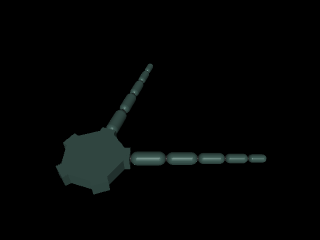

""

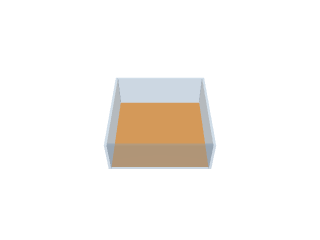

In [45]:
env_container = EnvContainer(config)
env_container.generate_env()
env_container.visualize_morphology()
env_container.visualize_arena()


In [46]:
print("MJX Observatin Space:")
print(f"\t{env_container.env.observation_space}")

print("MJX Action Space:")
print(f"\t{env_container.env.action_space}")

print("First 5 actuators:")
print(f"\tMJX: {env_container.env.actuators[:5]}")



MJX Observatin Space:
	Dict('joint_position': Box(-0.5235988, 0.5235988, (20,), <class 'jax.numpy.float32'>), 'joint_velocity': Box(-inf, inf, (20,), <class 'jax.numpy.float32'>), 'joint_actuator_force': Box(-inf, inf, (20,), <class 'jax.numpy.float32'>), 'actuator_force': Box([-5.  -5.  -4.5 -4.5 -4.  -4.  -3.5 -3.5 -3.  -3.  -5.  -5.  -4.5 -4.5 -4.  -4.  -3.5 -3.5 -3.
 -3. ], [5.  5.  4.5 4.5 4.  4.  3.5 3.5 3.  3.  5.  5.  4.5 4.5 4.  4.  3.5 3.5 3.  3. ], (20,), <class 'jax.numpy.float32'>), 'disk_position': Box(-inf, inf, (3,), <class 'jax.numpy.float32'>), 'disk_rotation': Box(-3.1415927, 3.1415927, (3,), <class 'jax.numpy.float32'>), 'disk_linear_velocity': Box(-inf, inf, (3,), <class 'jax.numpy.float32'>), 'disk_angular_velocity': Box(-inf, inf, (3,), <class 'jax.numpy.float32'>), 'segment_contact': Box(0.0, 1.0, (10,), <class 'jax.numpy.float32'>), 'segment_light_intake': Box(0.0, 1.0, (10,), <class 'jax.numpy.float32'>))
MJX Action Space:
	Box(-0.5235988, 0.5235988, (20,), <c

In [47]:
rng, rng_dummy_state = jax.random.split(rng, 2)
env_container.generate_dummy_state(rng_dummy_state)
print(env_container.dummy_state.observations)
print(env_container.dummy_state.observations.keys())

{'joint_position': Array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32), 'joint_velocity': Array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32), 'joint_actuator_force': Array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32), 'actuator_force': Array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32), 'disk_position': Array([-3.  ,  0.  ,  0.11], dtype=float32), 'disk_rotation': Array([-3.142,  0.   ,  0.   ], dtype=float32), 'disk_linear_velocity': Array([0., 0., 0.], dtype=float32), 'disk_angular_velocity': Array([0., 0., 0.], dtype=float32), 'segment_contact': Array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32), 'segment_light_intake': Array([0.849, 0.834, 0.824, 0.814, 0.804, 0.869, 0.864, 0.859, 0.854, 0.854], dtype=float32)}
dict_keys(['joint_position', 'joint_velocity', 'joint_actuator_force

In [34]:
dummy_action = np.zeros(len(env_container.env.actuators))
dummy_action[0] = 0.5
dummy_action[11] = -0.5
print(dummy_action)

[ 0.5  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  -0.5  0.   0.   0.   0.   0.   0.   0.
  0. ]


/home/idlab515/OneDrive/Documents/DOCUMENTEN/4_PhD/BSC/bsc/lib/python3.12/site-packages/jax/_src/interpreters/xla.py:133: RuntimeWarning: overflow encountered in cast
  return np.asarray(x, dtypes.canonicalize_dtype(x.dtype))
/home/idlab515/OneDrive/Documents/DOCUMENTEN/4_PhD/BSC/bsc/lib/python3.12/site-packages/jax/_src/interpreters/xla.py:133: RuntimeWarning: overflow encountered in cast
  return np.asarray(x, dtypes.canonicalize_dtype(x.dtype))
/home/idlab515/OneDrive/Documents/DOCUMENTEN/4_PhD/BSC/bsc/lib/python3.12/site-packages/jax/_src/interpreters/xla.py:133: RuntimeWarning: overflow encountered in cast
  return np.asarray(x, dtypes.canonicalize_dtype(x.dtype))
/home/idlab515/OneDrive/Documents/DOCUMENTEN/4_PhD/BSC/bsc/lib/python3.12/site-packages/jax/_src/interpreters/xla.py:133: RuntimeWarning: overflow encountered in cast
  return np.asarray(x, dtypes.canonicalize_dtype(x.dtype))
/home/idlab515/OneDrive/Documents/DOCUMENTEN/4_PhD/BSC/bsc/lib/python3.12/site-packages/jax/_src

[ 0.51  -0.017 -0.035 -0.012 -0.016 -0.007 -0.005 -0.003 -0.001 -0.001  0.007 -0.453 -0.008  0.053
 -0.007  0.044 -0.003  0.024 -0.001  0.011]


""

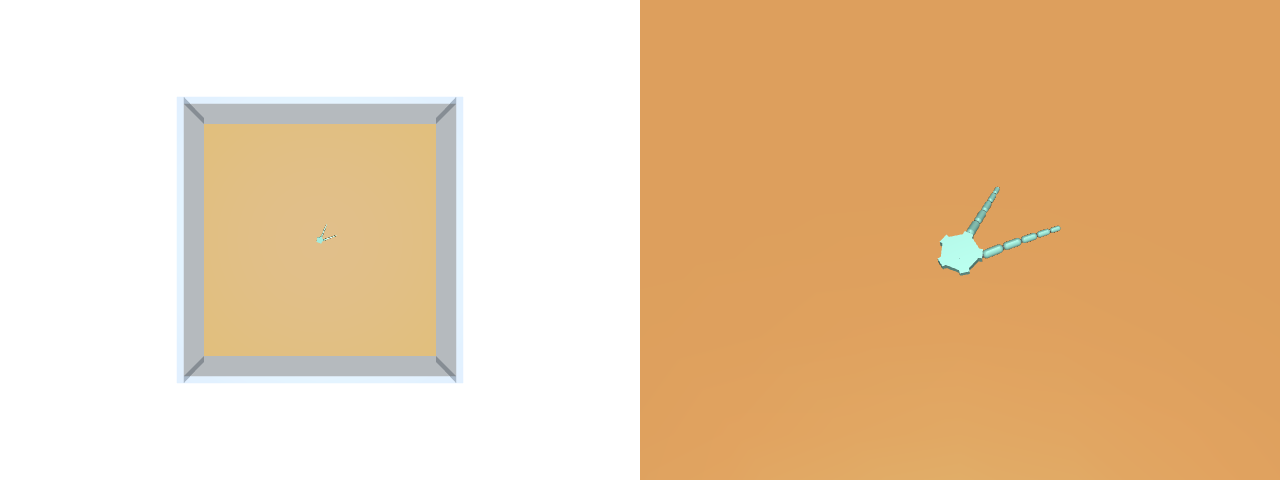

In [37]:
for i in range(10):
    env_container.dummy_state = env_container.env.step(state=env_container.dummy_state, action=dummy_action)
print(env_container.dummy_state.observations["joint_position"])
env_container.visualize_dummy_state()

In [39]:
print(env_container.dummy_state.observations)
print(env_container.dummy_state.observations.keys())

{'joint_position': Array([ 0.51 , -0.017, -0.035, -0.012, -0.016, -0.007, -0.005, -0.003, -0.001, -0.001,  0.007,
       -0.453, -0.008,  0.053, -0.007,  0.044, -0.003,  0.024, -0.001,  0.011], dtype=float32), 'joint_velocity': Array([-0.016, -0.778,  0.533, -0.062, -0.36 ,  0.033, -0.324,  0.018, -0.09 ,  0.004, -0.298,
       -0.316,  0.775,  0.917,  0.057,  0.266, -0.744, -0.373, -0.289,  0.01 ], dtype=float32), 'joint_actuator_force': Array([-0.506,  0.856,  1.727,  0.578,  0.8  ,  0.347,  0.27 ,  0.147,  0.049,  0.031, -0.33 ,
       -2.327,  0.382, -2.625,  0.371, -2.189,  0.149, -1.181,  0.061, -0.554], dtype=float32), 'actuator_force': Array([-0.506,  0.856,  1.727,  0.578,  0.8  ,  0.347,  0.27 ,  0.147,  0.049,  0.031, -0.33 ,
       -2.327,  0.382, -2.625,  0.371, -2.189,  0.149, -1.181,  0.061, -0.554], dtype=float32), 'disk_position': Array([-5.139e-07,  1.771e-03,  4.224e-02], dtype=float32), 'disk_rotation': Array([-3.035e+00,  1.023e-04,  2.687e-01], dtype=float32), 'di